<a href="https://colab.research.google.com/github/AlanAmaro13/YT_Network_Analysis/blob/main/An%C3%A1lisis_de_Red_YT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis a la red de YouTube


Por: Amaro, Alan.

## Descripción

A continuación presento un amplio análisis en relación a la red de YT. Esta red fue extraída de: [Youtube social network and groud-truth communities](https://snap.stanford.edu/data/com-Youtube.html). Del enlace: YouTube es una página donde se publican y comparten videos de la manera global, la plataforma posee una red social que permite formar relaciones con otros usuarios. En la red se considera a las relaciones que poseen 3 o más nodos como un grupo.


En el _dataset_ se presentan, acorde a la descripción, una red con 8,385 comunidades. Nuestro estudio se centra en la red no dirigida donde cada nodo describe a un usuario y cada enlace describe una relación.


* Para toda la generación y ejecución de la notebook se empleó Google Colaboratory y el uso de GPU.

* Dado que la red posee cerca de 1e6 nodos, consideré reducirla a solo 1e3 nodos para ciertas secciones.

## Librerias

Para toda la ejecución de esta notebook se recomienda utilizar un entorno de GPU, para permitir que Networkx emplee el uso de gráficas se recomienda ejecutar la siguiente celda:

In [ ]:
! pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


A su vez, recomendamos la instalación de las siguientes librerías:

In [ ]:
!pip install powerlaw

In [ ]:
! pip install tqdm

In [ ]:
import pandas as pd
import numpy as np
%env NX_CUGRAPH_AUTOCONFIG=True
import networkx as nx
import matplotlib.pyplot as plt
nx.config.warnings_to_ignore.add("cache")
import time
import random
from scipy.stats import poisson
import powerlaw
from collections import Counter
from tqdm import tqdm
import cv2
import numpy as np

env: NX_CUGRAPH_AUTOCONFIG=True


In [ ]:
print(nx.__version__)

3.4.2


In [ ]:
! pip install python-telegram-bot

In [ ]:
async def send_sms_to_me(sms: str):
  from telegram import Bot
  BOT_TOKEN = 1
  CHAT_ID = 1
  bot = Bot(token = BOT_TOKEN)
  await bot.send_message(chat_id=CHAT_ID, text = sms)

## Carga de datos



La información de la red se encuentra contenida un archivo _.txt_, en éste se presenta cada una de las conexiones entre nodo y nodo, para realizar la carga de la red se emplea la librería _Pandas_ para el filtrado de la misma y el método _from pandas edgelist_ para importar la red de un archivo _pd_ a una red en Networkx.

In [ ]:
# Enlace a nuestra información
data_path = '/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/com-youtube.ungraph.txt/com-youtube.ungraph.txt'

In [ ]:
# Visualizacion de la informacion
data = pd.read_csv(data_path, nrows =10, skiprows = 4, sep='\t', usecols = [0, 1], header = None)
data.head()

,0,1
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


In [ ]:
# Carga de la red
net = nx.from_pandas_edgelist(pd.read_csv(data_path, header = None, skiprows = 4, sep='\t', usecols = [0, 1]), source = 0, target = 1 )

## Propiedades generales de la red

A continuación presentamos las propiedades generales de la red, tal como número de nodos, enlaces y su visualización.

In [ ]:
# Nodos
nodos = net.number_of_nodes()
print('La red contiene {:.2e} nodos'.format(nodos))

# Enlaces
enlaces = net.number_of_edges()
print('La red contiene {:.2e} enlaces'.format(enlaces))

La red contiene 1.13e+06 nodos
La red contiene 2.99e+06 enlaces


Para calcular el grado promedio consideramos la siguiente expresión:
$$\langle k \rangle = \frac{2L}{N} $$

In [ ]:
avg_k = 2*enlaces/nodos
print('El grado promedio de la red corresponde a {:.3}'. format(avg_k))

El grado promedio de la red corresponde a 5.27


El clustering de un nodo se define a partir de la siguiente expresión:
$$C_{i} = \frac{2 L_{i}}{k_{i}(k_{i} -1 )} $$
Para obtener el valor promedio de clustering consideramos la siguiente función de Networks:

In [ ]:
avg_c = nx.average_clustering(net)
print('El clustering promedio de la red corresponde a {:.3e}'.format(avg_c))

El clustering promedio de la red corresponde a 8.080e-02


* Para obtener el diamétro de la red junto con otras propiedades requierimos de una potencia lcomputacional mayor de la permitida por Google Colaboratory. Para realizar una aproximación consideramos una sub-red generada a partir de los primeros 5,000 nodos.

In [ ]:
#nodos = [random.randint(0, int(nodos)) for _ in range(int(30e3))] # Nodos aleatorios
nodos = [i for i in range(0, int(5e3) )] # Primeros 5k

subnet = net.subgraph(nodos) # Tomamos el subgrafo junto con sus conexiones

#print('Nodos en el subgrafo: ', subnet.nodes())
#print('Enlaces en el subgrafo:', subnet.edges())

net = nx.Graph(subnet) # Generamos el nuevo subnet

Donde esta sub-red cuenta con las siguientes propiedades

In [ ]:
# Nodos
nodos = net.number_of_nodes()
print('La red contiene {:.2e} nodos'.format(nodos))

# Enlaces
enlaces = net.number_of_edges()
print('La red contiene {:.2e} enlaces'.format(enlaces))

avg_k = 2*enlaces/nodos
print('El grado promedio de la red corresponde a {:.3}'. format(avg_k))

avg_c = nx.average_clustering(net)
print('El clustering promedio de la red corresponde a {:.3e}'.format(avg_c))

La red contiene 5.00e+03 nodos
La red contiene 4.60e+04 enlaces
El grado promedio de la red corresponde a 18.4
El clustering promedio de la red corresponde a 2.736e-01


El diámetro de la red corresponde a la distancia máxima entre dos nodos, para determinar tal valor considreamos la siguiente función de la librería Networks:

In [ ]:
diameter = nx.diameter(net)
print('El diametro de la red corresponde {}'.format(diameter))

El diametro de la red corresponde 5


In [ ]:
#await send_sms_to_me('Diameter completed!')

## Medidas de centralidad

A continuación presentamos un representación de las mediadas de centralidad, dado que esta red corresponde a una red social, consideramos relevantes para el análisis las siguientes métricas:
* Centralidad de cercanía: Esta métrica de red se representa a partir de la siguiente expresión:
$$C_{c} = \frac{N-1}{\sum_{j} d_{ij}} $$
Esta métrica cuantifica la relevancia de un nodo a partir de su cercanía a los otros nodos, en términos de nuestra red, podría interpretarse como un usuario con un número alto de amistades dentro de la red.
* Centralidad de intermediación: Esta métrica se representa a partir de la siguiente expresion:
$$C_{B} = \frac{ 1 + 2 \sum_{s<t} \frac{g_{st}^{i}}{g_{st} }  }{N^{2}}$$
Esta métrica cuantifica la relevancia del nodo a partir de flujo de información a través del mismo. En términos de nuestra red podría intrepretarse como un usuario que conecta con grupos de diversos y actúa como puente entre diversas comunidades.

In [ ]:
c = nx.closeness_centrality(net)
cercania = [ c[nodo] for nodo in net ]

inter = nx.betweenness_centrality(net)
intermediacion = [ inter[nodo] for nodo in net ]

Graficamos la medición de cada medida de centralidad:

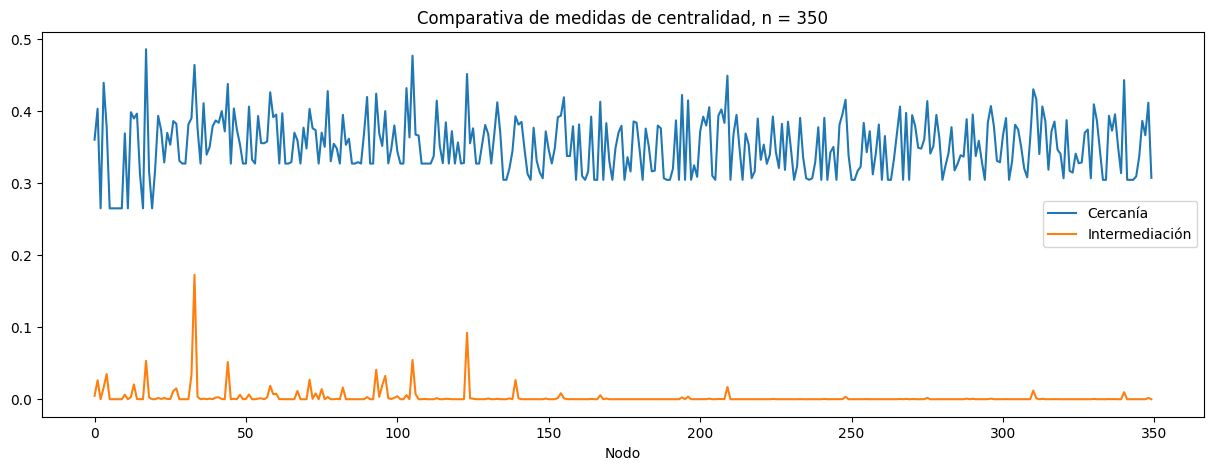

In [ ]:
plt.figure(figsize = [15, 5])
n = 350
plt.plot(cercania[:n], label = 'Cercanía')
plt.plot(intermediacion[:n], label = 'Intermediación')
plt.xlabel('Nodo')
plt.title('Comparativa de medidas de centralidad, n = {}'.format(n))
plt.legend()
plt.show()


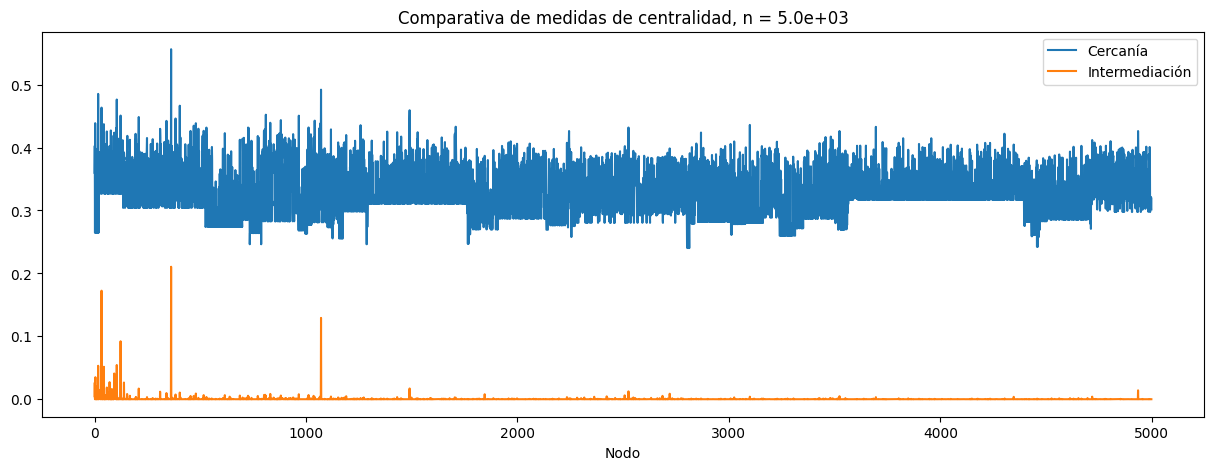

In [ ]:
plt.figure(figsize = [15, 5])
n = len(cercania)
plt.plot(cercania[:n], label = 'Cercanía')
plt.plot(intermediacion[:n], label = 'Intermediación')
plt.xlabel('Nodo')
plt.title('Comparativa de medidas de centralidad, n = {:.1e}'.format(n))
plt.legend()
plt.show()


In [ ]:
#await send_sms_to_me('Metrics completed!')

Para obtener una representación visual de la red seleccionamos los primeros 500 nodos de la red, a partir de la cual obtenemos las mediadas de centralidad antes mencionadas y gráficamos en función de estas métricas. Asignamos el tamaño de los nodos a la métrica de intermediación y el color de los mismos a la métrica de cercanía.

In [ ]:
# Seleccionamos los primeros 1000 nodos
nodos = [i for i in range(500)] # Lista de 0 al 999

subnet = net.subgraph(nodos) # Tomamos el subgrafo junto con sus conexiones

print('Nodos en el subgrafo: ', subnet.nodes())
print('Enlaces en el subgrafo:', subnet.edges())

subnet = nx.Graph(subnet) # Generamos el nuevo subnet

# Obtenemos las medidas de centralidad

c = nx.closeness_centrality(subnet)
cs = [ c[nodo] for nodo in subnet ]

inter = nx.betweenness_centrality(subnet)
bs = [ inter[nodo] for nodo in subnet ]


Nodos en el subgrafo:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

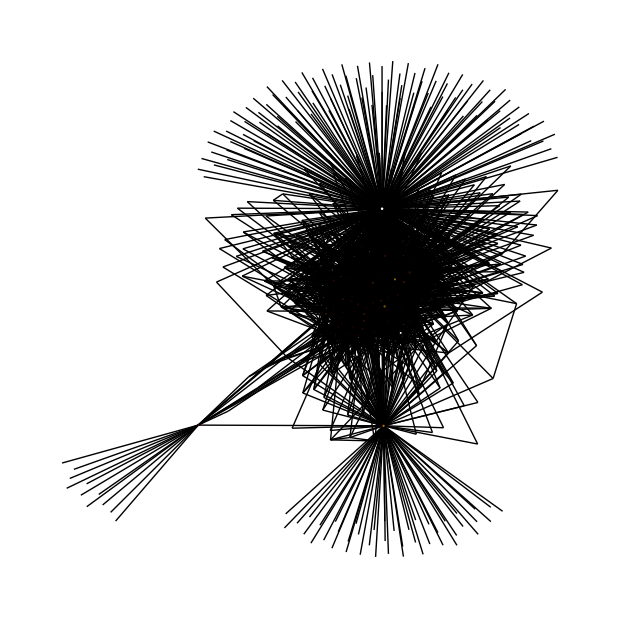

In [ ]:
# Generamos la representación:
plt.figure(figsize = [6,6])

nx.draw(subnet,
        node_size = bs,
        node_color = cs,
        cmap = 'hot')

plt.savefig('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/RED1.png', dpi = 300)

In [ ]:
#await send_sms_to_me('Figure completed!')

## Distribución de grado

Para obtener la distribución de grado obtenemos el grado de cada nodo, generamos una distribución mediante la iteración con un diccionario.

La  _key_ del diccionario representa el grado del nodo y el _value_ representa la cantidad de nodos con el mismo grado.

In [ ]:
# Obtenemos los grados de cada nodo
D = net.degree() # (nodo, grado)
dict_D = dict(D) # nodo:grado
grados = [dict_D[i] for i in net] # Para cada nodo de la red obten el grado

# Generamos la distribucion
distribucion = {}

for i in grados:
  distribucion[i] = 0

for i in grados:
  distribucion[i] +=1 # Grado: Valor

In [ ]:
X = list(distribucion.keys())
Y = list(distribucion.values())

Obtenemos los valores máximos de cada conjunto:

In [ ]:
max(Y)

602539

In [ ]:
max(X)

28754

Gráficamos la distribución de grado a partir de los valores X,Y. En este caso seleccionamos como la mejor representación a la escala logarítmica.

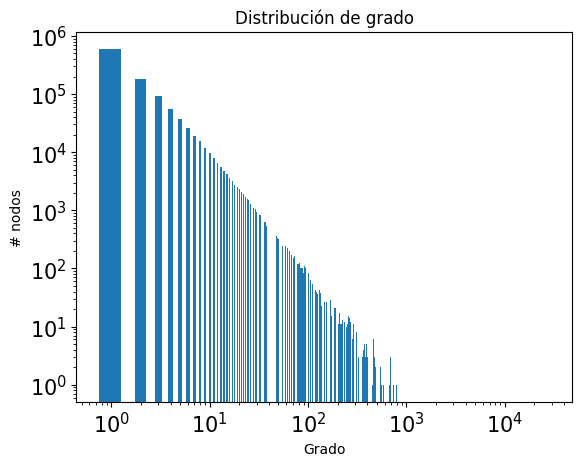

In [ ]:
plt.figure()
plt.bar(X, Y, width= 0.5)

plt.xlabel('Grado')
plt.ylabel('# nodos')
plt.xticks(ticks = range(1,max(X)+1),labels = range(1,max(X)+1), size = 15)
plt.yticks(size = 15)
plt.yscale('log')
plt.xscale('log')
plt.title('Distribución de grado')
plt.show()

A su vez consideramos la representación del grado en términos de su frecuencia:

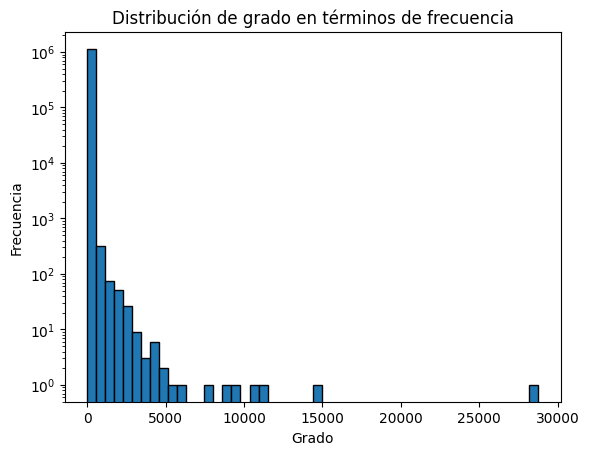

In [ ]:
bins = 50
counts, edges = np.histogram(grados, bins = bins)

bin_centers = 0.5 * ( edges[:-1] + edges[1:] )

plt.bar(bin_centers, counts, width=edges[1] - edges[0], edgecolor='black')
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.xscale('linear')
plt.title('Distribución de grado en términos de frecuencia')
plt.show()

## Interpretación de los resultados

Nuestra red es de 1 millón de nodos, con cerca de 3 millones de conexiones. La distribución de grado muestra que cerca de un millón de nodos poseen menos de 10 relaciones con otros nodos, este resultado sugiere que la red _no posee relaciones aleatorias_ y presenta un comportamiento de ley de potencia.


Esta conjetura es reforzada a partir de la representación de la distribución de grado en escala logarítmica, donde se observa un comportamiento lineal decreciente. Encontramos que un nodo puede poseer cerca de 10,000 relaciones. A su vez, de la representación de la frecuencia de grado encontramos nodos que poseen cerca de 30,000 relaciones.

El diámetro de la red _para los primeros 5,000 nodos_, sugiere que nuestra red sigue un comportamiento de mundo pequeño, dado que el diámetro máximo alcanzado por la red corresponde a 5. Si consideramos la expresión de caracterización de mundo pequeño:
$$d_{max} \approx \frac{\log N}{\log \langle k \rangle} $$

In [ ]:
d = np.log(3e4) / np.log(17.3)
d

3.616279913490348

Para nuestra selección de los primeros 5,000 nodos la propiedad de mundo pequeño no se satisface. En cambio si consideramos el tamaño completo de la red junto al valor reporta de diámetro, se obtiene:

In [ ]:
d = np.log(1.13e6) / np.log(5.27)
d

8.38596484439483

Donde el diámetro reportado corresponde a:

$$d_{YT} = 20 $$

En este caso se satisface la propiedad de posee un diámetro pequeño en relación al tamaño de la red. Sin embargo, para que la propiedad de mundo pequeño se cumpla en nuestra red, se debe tener un valor alto de clustering, en cambio en nuestra red se presenta un valor de:
$$C =  8e-2$$
Por ende, nuestra red _no satisface_ la propiedad de mundo pequeño. El resultado de un clustering pequeño puede ser interpretado de la siguiente manera: Dada la naturaleza de nuestra red, dentro de la red social de YouTube no tienden a formarse comunidades.

## Comparación con modelos

### Comparación con una red aleatoria

En el caso de las redes aleatorias se satisface que el valor de clustering promedio:
$$\langle c \rangle = p$$
Obtenemos este par de valores para la red completa:  

In [ ]:
C = nx.average_clustering(net)
C

0.08080227776190227

In [ ]:
p = avg_k / (nodos - 1)
p

4.639260713241579e-06

De los valores anteriores podemos observar que el clustering promedio y el valor de la probabilidad difieren en cerca de 4 órdenes de magnitud. De tal manera que nuestra red no satisface ser modelada a partir de una red aleatoria, como se pueda observar en el siguiente gráfico:

In [ ]:
# Obtenemos de los valores de grado
grado_dict = dict(nx.degree(net))
clustering_dict = nx.clustering(net)


In [ ]:
# Generamos DF de Grado - Clustering
df = pd.DataFrame([grado_dict, clustering_dict]).T
df.columns = ['Grado', 'Clustering']
df

,Grado,Clustering
1,29.0,0.004926
2,256.0,0.030913
3,12.0,0.106061
4,2753.0,0.004222
5,192.0,0.012162
...,...,...
1157823,1.0,0.000000
1157824,1.0,0.000000
1157825,1.0,0.000000
1157826,1.0,0.000000


In [ ]:
# Generamos el histograma
K = df.Grado.max()
y,x = np.histogram(df.Grado.values, bins = range(int(K)+1), density=True)

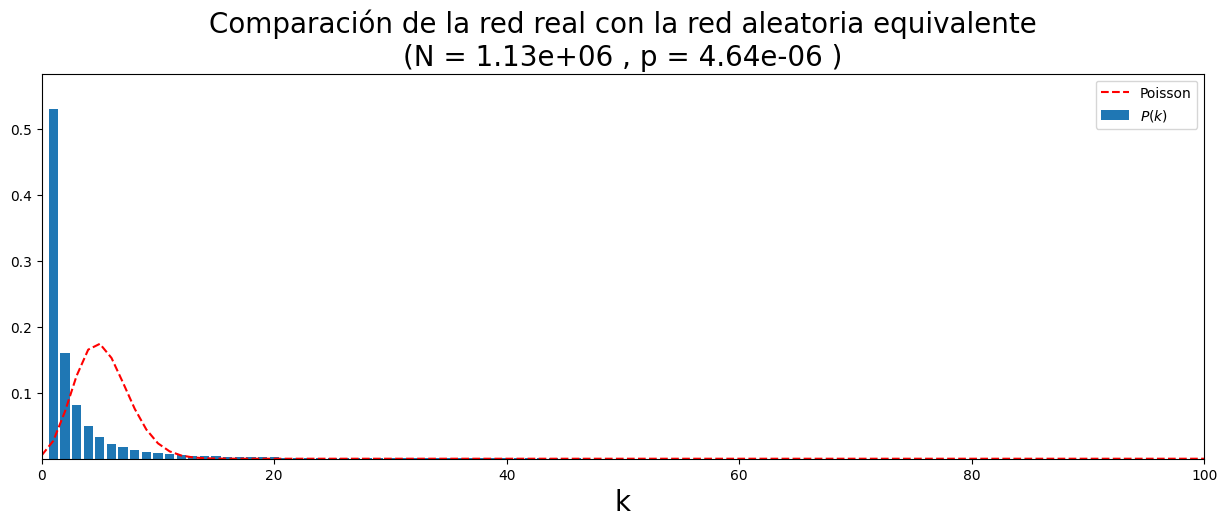

In [ ]:
plt.figure(figsize = [15,5])
plt.bar(x[:-1], y, label = r'$P(k)$')
plt.plot(x[:-1], poisson.pmf(x[:-1], avg_k), 'r--', label = 'Poisson')

plt.ylim([0.5*y[y>0].min(),1.1*y.max()])
plt.xlim([0,100])
plt.legend()
plt.title('Comparación de la red real con la red aleatoria equivalente\n(N = {:.2e} , p = {:.2e} )'.format(nodos,p), size = 20)
plt.xlabel('k', size = 20)
plt.show()

La gráfica anterior sugiere que nuestra no presenta un comportamiento aleatorio. La distribución de Poisson, característica de las redes de Erdos-Reyni, no predice correctamente la probabilidad de grado de la red.

* En cambio, si consideramos estos valores en escala logarítmica:

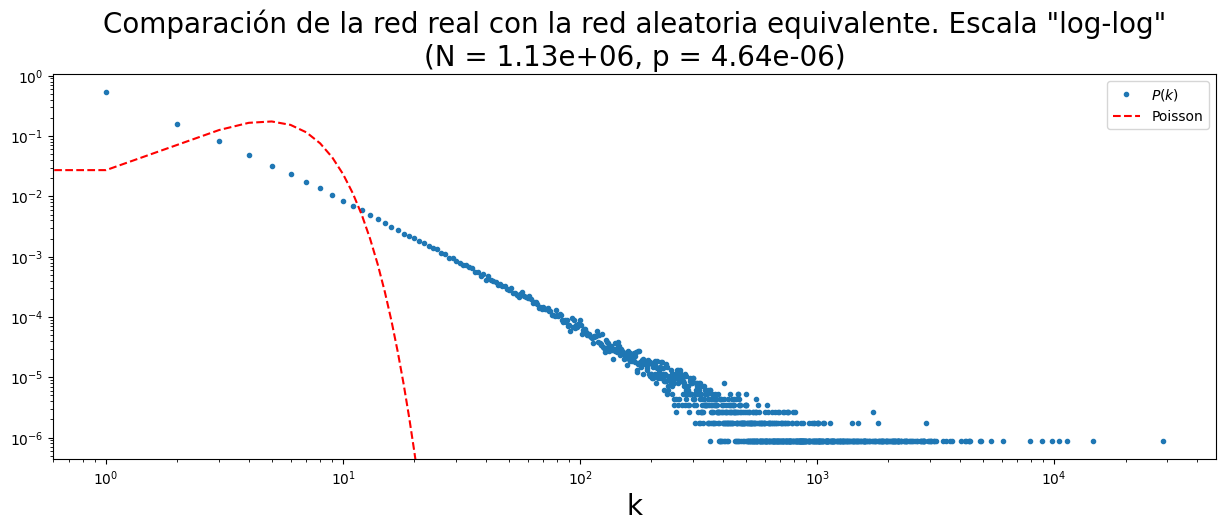

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(x[:-1], y, '.', label = r'$P(k)$')
plt.plot(x[:-1], poisson.pmf(x[:-1], avg_k), 'r--', label = 'Poisson')

#Se aplica escala logarítmica a ambos ejes
plt.xscale('log')
plt.yscale('log')

#parámetros adecuados para la visualización:
plt.ylim([0.5*y[y>0].min(),2*y.max()])
plt.legend()

plt.title('Comparación de la red real con la red aleatoria equivalente. Escala "log-log"\n(N = {:.2e}, p = {:.2e})'.format(nodos,p), size = 20)
plt.xlabel('k', size = 20)
plt.show()

Estos resultados sugieren que la probabilidad de grado es modelable a partir de una ley de potencia.

### Comparación con una red con independencia de escala

El gráfico anterior sugiere que la probabilidad de grado de nuestra red es modelable apartir de una ley de potencia. Para demostrar esta conjetura consideramos los grados de la red:

In [ ]:
# Generamos el diccionario de grados
grado_dict = dict(nx.degree(net))
Degree = np.array([grado_dict[nodo] for nodo in net])

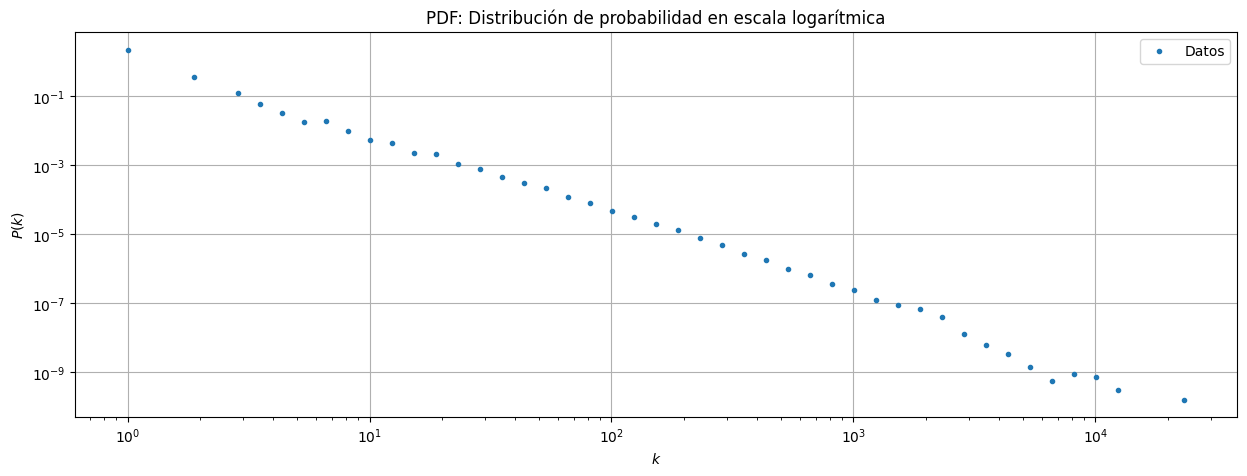

In [ ]:
# Visualizamos el grado de la red
K = Degree.max()

# Realizamos el histograma
y0, x0 = np.histogram(Degree,
                      bins = np.logspace(0, np.log10(K+2)) , # bins = range( int(K+2) ) para regular
                      density = True
                      )

plt.figure(figsize = [15,5])
plt.plot(x0[:-1], y0, '.', label = 'Datos')
plt.xscale('log')
plt.yscale('log')
plt.title('PDF: Distribución de probabilidad en escala logarítmica')
plt.legend()
plt.grid()
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.show()

Al considerar la distribución de probabilidad de grado en escala logarítmica observamos una tendencia lineal decremiente, de tal forma que nuestra red presenta independencia de escala. Es decir, la probabilidad de grado es de la forma:
$$P(k) = Ck^{-\alpha} $$


Para encontrar el valor de $\alpha$ empleamos la librería PowerLaw, de dónde obtenemos el valor $k_{min}$ a partir del cual se satisface el paramétro $\alpha$.

In [ ]:
fit = powerlaw.Fit(Degree) # Metodo empleado
alpha = fit.alpha
kmin = fit.xmin

Calculating best minimal value for power law fit


In [ ]:
print('Alpha: {:.2e} - Kmin: {:.2e}'.format(alpha, kmin))

Alpha: 2.48e+00 - Kmin: 2.06e+02


De dónde obtenemos:

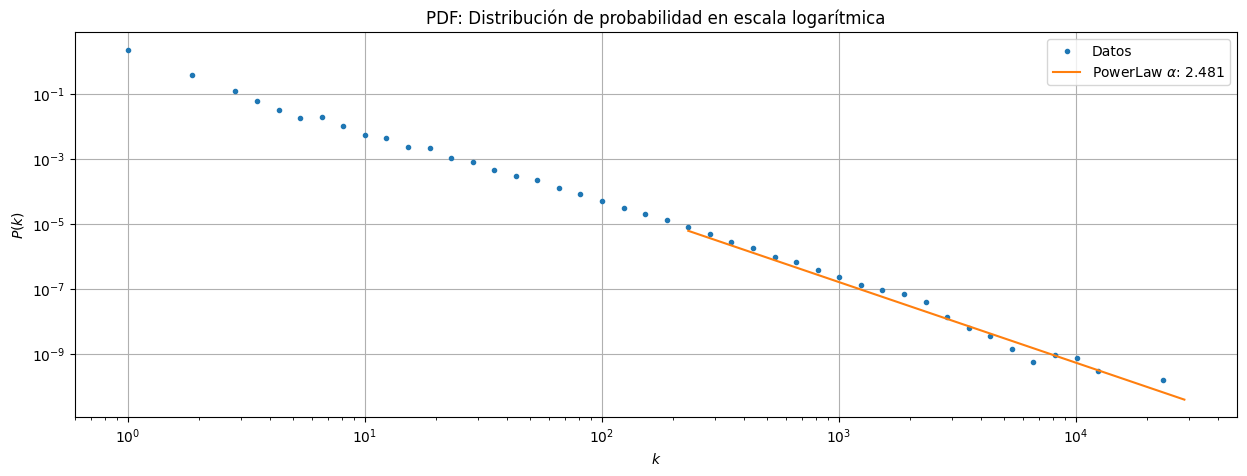

In [ ]:
n = 4.5
y = lambda k: n*k**(-alpha)
x = x0[x0>= kmin]
y_v = y(x)

plt.figure(figsize = [15,5])
plt.plot(x0[:-1], y0, '.', label = 'Datos')
plt.plot(x, y_v, label = r'PowerLaw $\alpha$: {:.3f}'.format(alpha) )
plt.xscale('log')
plt.yscale('log')
plt.title('PDF: Distribución de probabilidad en escala logarítmica')
plt.legend()
plt.grid()
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.show()

El valor $\alpha$ al cual se ajusta mejor la tendencia de la probabilidad de grado corresponde a $2.48$, donde el valor $k_{min}$ corresponde a $206$. Este resultado confirma el comportamiento de independecia de escala de la red, y la presencia de Hubs dentro de la misma.

### Interpretación

Los resultados presentados en esta sección sugieren que nuestra red no es modelable a partir de redes aleatorias, dada a la diferencia en órdenes de magnitud del clustering y el valor esperado de probabilidad de la red. A su vez, la distribución de probabilidad de grado no es modelable a partir de una distribución de Poisson.

Al gráficar la distribición de probabilidad de grado en escala logarítmica observamos una tendencia lineal, esto sugiere que nuestra red presenta independencia de escala. Este resultado es reforzado a partir de la obtención del coeficiente $\alpha$, el cual modela correctamente el comportamiento de la red en la región $[10^{2}, 10^{4}]$

En comparación con la naturaleza de los nodos y los enlaces, este resultado sugiere que en nuestra red se da la presencia de individuos (nodos) que presenta una alta cantidad de relaciones (enlaces), al tratarse de una red social, este resultado puede interpretarse como la presencia de _celebridades_ o _influencers_ en la misma.

## Proceso

### Vacunación aleatoria

El proceso a simular en nuestra red corresponde a _Difusión_. Partícularmente consideramos la simulación de la propagación del COVID-19 empleando el modelo SIS: Susceptible-Infectado-Susceptible.

**Descripción:** Durante el año 2020 tuvo lugar el surgimiento y propagación del virus SARS-Cov-2 como epidemia global. Este virus con alto índice de propagación se esparció rápidamiente a través de distintos países.

**Descripción del modelo**: Para simular el proceso de esparcimiento de la enfermedad consideramos el modelo SIS: Susceptible Infectado Susceptible. En este modelo se consideran los siguientes estados para cada nodo (persona):
* Susceptible: Este es el caso de una persona sana que puede contagiarse del virus.
* Infectado: Este es el caso de una persona portadora del virus (no puede infectarse dado que ya está infectado)
* Susceptible* : Este es el caso de una persona infectada que se ha recuperado del virus, puede volver a enfermarse con menor probabilidad.
* Vacuando: Este es el caso de una persona vacunada. En el simplificación de este modelo consideramos que las personas vacuandas no pueden volver a infectarse, siendo este estado permanente.



Dentro del modelo SIS consideramos las siguientes transiciones de estados:
* Susceptible a Infectado: Una persona sana puede convertirse en infectada con cierta probabilidad $a_{1}$ si ha estado en contacto con una persona infectada. A mayor cantidad de contactos, mayor probabilidad.

* Infectado a Susceptible*: Una persona infectada puede recuperarse de la enfermadad con cierta probabilidad $b_{1}$.

* Susceptible* a infectado: Una persona recuperada puede volver a enfermarse con cierta probabilidad $a_{2} = a_{1}/3$.

* Susceptible o susceptible* a vacunado: Una persona sana o recuperada puede vacunarse contra la enfermedad.

**Metodología**: Para simular este proceso de difusión dentro de la red inicializmaos los estados con una pequeña cantidad de infectados, e iterados sobre la red.

Consideramos que las personas se vacunan a través del tiempo (iteraciones) con cierta probabilidad.

In [ ]:
# Parametros
p_inf = 0.01 # Porcentaje de infeccion
iter = 150 # Iteraciones o dias

## Enfermedad
a1 = 0.3 # Transicion de S a I
b = 0.1  # Transicion de I a S*
a2 = a1/3 # Transicion de S* a I
pv = 0.05  # Transicon de S, S* a V

Inicializamos los estados de la red, al ser este paso el día 0 de la enfermedad únicamente podemos inicializar los estados de susceptible e infectados. Los estados de susceptibles* y vacunados permancene nulos.

In [ ]:
for nodo in net.nodes():
  net.nodes[nodo]['Estado'] = 'I' if random.random() < p_inf else 'S' # Infectado o Susceptible

Verificamos los estados:

In [ ]:
_states = [ net.nodes[nodo]['Estado'] for nodo in net.nodes() ]

In [ ]:
_S = Counter(_states)['S']
_I = Counter(_states)['I']
_S, _I

(1123515, 11375)

In [ ]:
print('Porcentaje de infectados: {:.2f}'.format(_I/nodos * 100))

Porcentaje de infectados: 1.00


De donde se tiene cerca del 1% de infectados en la red para el día 0. Para obtener la cantidad de estados en la red, implementamos la siguiente función de contador:

In [ ]:
# Definimos un contador
def contador(red):
    counts = {'S': 0, 'I': 0, 'S*': 0, 'V':0}
    for nodo in red.nodes:
        counts[ red.nodes[nodo]['Estado'] ] += 1
    return counts

Realizamos la interación, para cada nodo obtenemos su estado.
* Si el estado es S, obtenemos la cantidad de infectados a su alrededor y asignamos la probabilidad de contagio como:
$$1 - (1-a_{1})^{cI} $$
Donde $cI$ se refiere a la cantidad de infectados como vecinos.

* Si el estado es I, le asignamos una probabilidad de recuperación para convertirse al estado S*.

* Si el estado es S*, le asignamos una probabilidad menor de convertirse en I.

* A partir de la iteración 200 comenzamos a vacunar de manera aleatoria a la población. Una vez que el estado del nodo sea $V$ éste dejará de interactuar con sus vecinos.

In [ ]:
net.nodes[1]['Estado'] # Ejemplo del estado de un nodo

'S'

In [ ]:
len([vecino for vecino in net.neighbors(3)]) # Vecinos del nodo 3

12

In [ ]:
sum([1 for vecino in net.neighbors(3) if net.nodes[vecino]['Estado'] == 'I']) # Cantidad de vecinos infectados del nodo 3

0

Declaramos el tiempo a partir del cual se empiece a vacunar a las personas:

In [ ]:
dv = 12

* Esta función obtiene el estado actual de la red y la convierte en una matriz:

In [ ]:
def state_to_matrix(network):
  dict_states = nx.get_node_attributes(network, 'Estado') # Dict: nodo - estado
  states = list(dict_states.values())
  norm = 255

  dict_mapeo = {'S': (0,255,0),  # Green
                'I': (0,0,255), # Red
                'S*': (33,222, 255), # Yellow
                'V': (0, 0, 0)}

  new_states = np.array( [ dict_mapeo[estado] for estado in states] + [(0,0,0)] * 400)
  output = np.reshape(new_states, (1066, 1065, 3) )
  return output

In [ ]:
D = state_to_matrix(net)

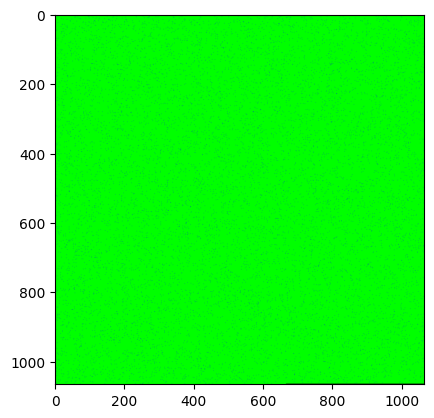

In [ ]:
plt.imshow(D)
plt.show()

Realizamos la iteración del proceso de difusión:

In [ ]:
# Simulamos el proceso
contador_estados = []
images = []
for it in tqdm(range(iter), desc = 'Iterando...'): # Consideramos 1k dias
  nuevos_estados = {} # Almacenamos el estado de la red

  for nodo in net.nodes: # Para cada nodo de los posibles nodos
    if net.nodes[nodo]['Estado'] == 'S': # Si el estado es susceptible
      # Obtiene a los vecinos
      cluster_infectados = sum(
          [1 for vecino in net.neighbors(nodo) if net.nodes[vecino]['Estado'] == 'I']
       )

      # Definimos el nuevo estado
      #'''
      if (random.random() < pv and it >= dv):
        nuevos_estados[nodo] = 'V'
      #'''

      elif random.random() < 1 - (1 - a1)**cluster_infectados: # Elif to if
        nuevos_estados[nodo] = 'I'

      else:
        nuevos_estados[nodo] = 'S'


    elif net.nodes[nodo]['Estado'] == 'I': # Si tenemos un infectado

      if random.random() < b:
        nuevos_estados[nodo] = 'S*'

      else:
        nuevos_estados[nodo] = 'I'

    elif net.nodes[nodo]['Estado'] == 'S*': # Estado Susceptible

      cluster_infectados = sum(
          [1 for vecino in net.neighbors(nodo) if net.nodes[vecino]['Estado'] == 'I']
       )

      # Definimos el nuevo estado
      #'''
      if (random.random() < pv and it >=dv):
        nuevos_estados[nodo] = 'V'
      #'''

      elif random.random() < 1 - (1 - a2)**cluster_infectados: # elif to if
        nuevos_estados[nodo] = 'I'

      else:
        nuevos_estados[nodo] = 'S*'

    elif net.nodes[nodo]['Estado']== 'V':
      nuevos_estados[nodo] = 'V' # Consideramos que los vacunados ya no pueden volver a infectar

    else:
      print('Esto no deberia pasar')


    # Actualizamos
  for nodo, ns in nuevos_estados.items():
    net.nodes[nodo]['Estado'] = ns

    # Almacenamos el historial

  contador_estados.append(contador(net))
  images.append(state_to_matrix(net))

Iterando...: 100%|██████████| 150/150 [11:31<00:00,  4.61s/it]


Obtenemos los valores de cada estado:

In [ ]:
dias = range(iter+1)

Sv = np.array( [_S] + [estado['S'] for estado in contador_estados])/nodos
Iv = np.array([_I] + [estado['I'] for estado in contador_estados])/nodos
S_v = np.array([0] + [estado['S*'] for estado in contador_estados])/nodos
Vv = np.array([0] + [estado['V'] for estado in contador_estados])/nodos

In [ ]:
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Sv.npy', Sv)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Iv.npy', Iv)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/S_v.npy', S_v)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Vv.npy', Vv)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulation.npy', np.array(images) )

In [ ]:
'''
dias = range(iter+1)
Sv = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Sv.npy')
Iv = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Iv.npy')
S_v = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/S_v.npy')
Vv = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Vv.npy')
'''

"\ndias = range(iter+1)\nSv = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Sv.npy')\nIv = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Iv.npy')\nS_v = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/S_v.npy')\nVv = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/Vv.npy')\n"

Realizamos la gráfica para los primeros 15 días de los posibles estados:

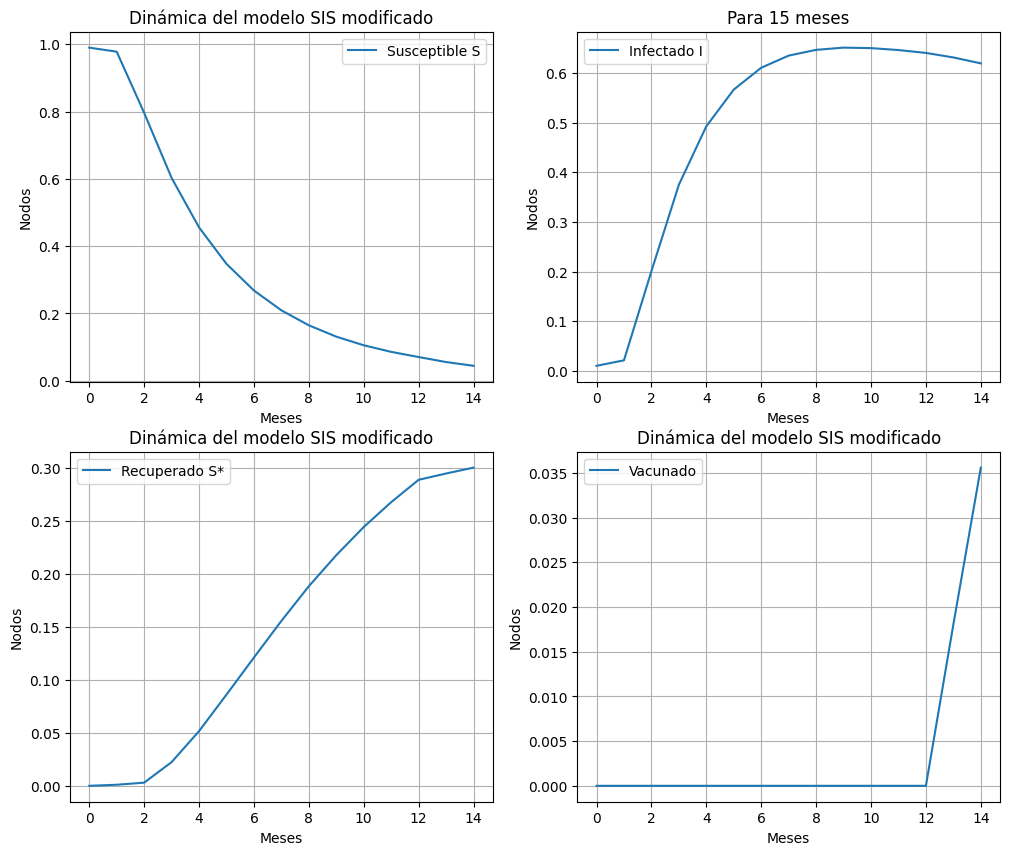

In [ ]:
# Grafica
n = 15
r = 10
plt.figure(figsize=(r+2, r ))
plt.subplot(2, 2, 1)
plt.plot(dias[:n], Sv[:n], label ='Susceptible S')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 2)
plt.plot(dias[:n], Iv[:n], label ='Infectado I')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Para {} meses'.format(n))

plt.subplot(2, 2, 3)
plt.plot(dias[:n], S_v[:n], label ='Recuperado S*')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 4)
plt.plot(dias[:n], Vv[:n], label ='Vacunado')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.show()

Realizamos la gráfica para todos los meses:

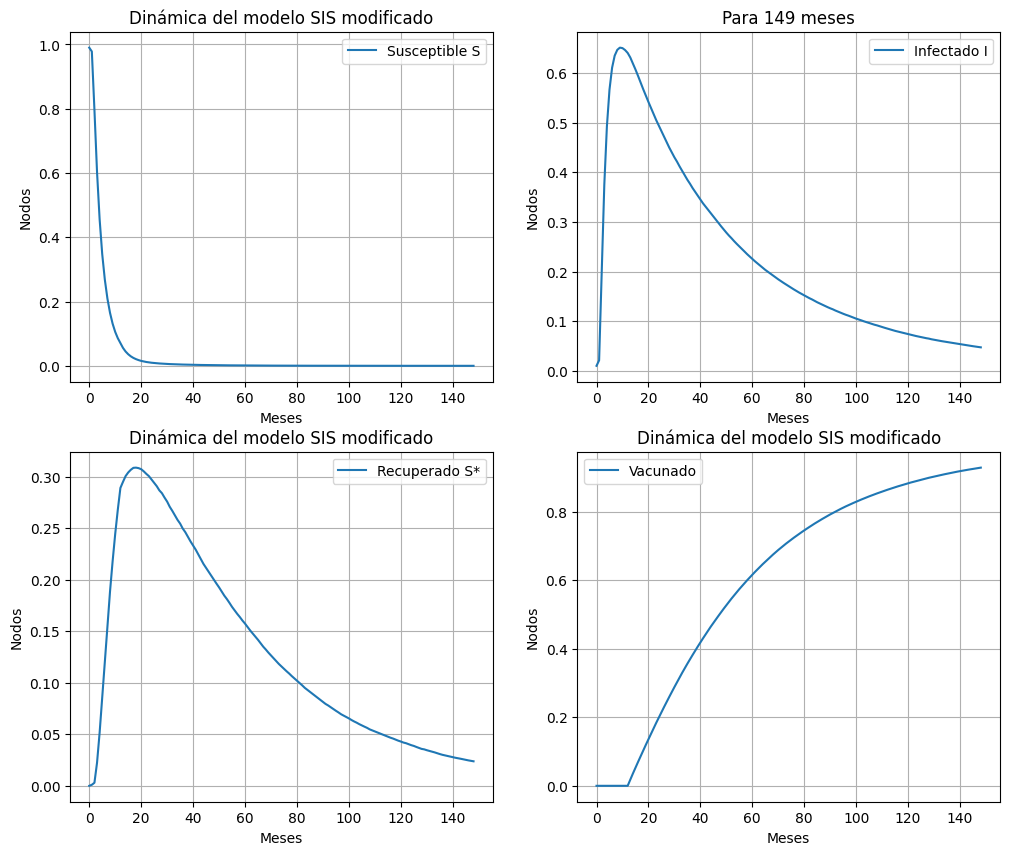

In [ ]:
# Grafica
n = iter - 1
r = 10
plt.figure(figsize=(r+2, r ))
plt.subplot(2, 2, 1)
plt.plot(dias[:n], Sv[:n], label ='Susceptible S')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 2)
plt.plot(dias[:n], Iv[:n], label ='Infectado I')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Para {} meses'.format(n))

plt.subplot(2, 2, 3)
plt.plot(dias[:n], S_v[:n], label ='Recuperado S*')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 4)
plt.plot(dias[:n], Vv[:n], label ='Vacunado')
plt.xlabel('Meses')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.show()

In [ ]:
#await send_sms_to_me('Diffusion completed!')

Hemos almacenado el estado de la red en una matriz RGB, lo que realizamos en la siguiente celda es convertirlo a un video donde cada frame sea de un segundo:

In [ ]:
_images = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulation.npy')

In [ ]:
_images.shape

(150, 1066, 1065, 3)

In [ ]:
data = _images.astype(np.uint8)  # Convertir a uint8 para OpenCV

In [ ]:
# Parámetros del video
output_path = '/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulationa1.mp4'
fps = 1  # Frames por segundo
height, width, _ = data.shape[1:]

In [ ]:
# Inicializamos el escritor de video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec para MP4
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Iteramos sobre cada frame y lo escribimos en el video
for frame in data:
    out.write(frame)

# Liberamos el objeto del video
out.release()

print(f"Video guardado en {output_path}")


Video guardado en /content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulationa1.mp4


El vídeo obtenido puede consultarse en [Propagación de Enfermedad en Vacunación Aleatoria](https://youtube.com/shorts/ZfC5f-aZ4cA?feature=share)

### Vacunación en Hubs

En este caso realizamos un procesimiento análogo al caso anterior, con la diferencia de que vacunamos a una cierta porción de los Hubs en cada época. Implementamos una función que nos devuelve a los Hubs de la red:

In [ ]:
def get_hubs(net, top): # Red y cantidad de hubs a devolver
  degrees = dict(net.degree())

  sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

  return sorted_nodes[:top]

In [ ]:
get_hubs(net, 5) # Devuelve a los primeros 5 hubs

[(1072, 28754), (363, 14641), (35661, 11281), (106, 10461), (482709, 9762)]

In [ ]:
def state_to_matrix(network):
  dict_states = nx.get_node_attributes(network, 'Estado') # Dict: nodo - estado
  states = list(dict_states.values())
  norm = 255

  dict_mapeo = {'S': (0,255,0),  # Green
                'I': (0,0,255), # Red
                'S*': (33,222, 255), # Yellow
                'V': (255, 0, 0)}

  new_states = np.array( [ dict_mapeo[estado] for estado in states] + [(0,0,0)] * 400)
  output = np.reshape(new_states, (1066, 1065, 3) )
  return output

Dado que consideramos 15 hubs vacunados a partir de la época 8, y consideramos 150 iteraciones, obtenemos los principales 2130 hubs

In [ ]:
hubs = list(dict(get_hubs(net, 2130+300)).keys())
hubs[:5]
hubs = set(hubs)

Iterados sobre la red. Empezamos la vacunación a partir de la iteración 8, vacunando a 15 hubs en cada iteración.

Propagación de la enfermedad: 100%|██████████| 150/150 [13:20<00:00,  5.34s/it]


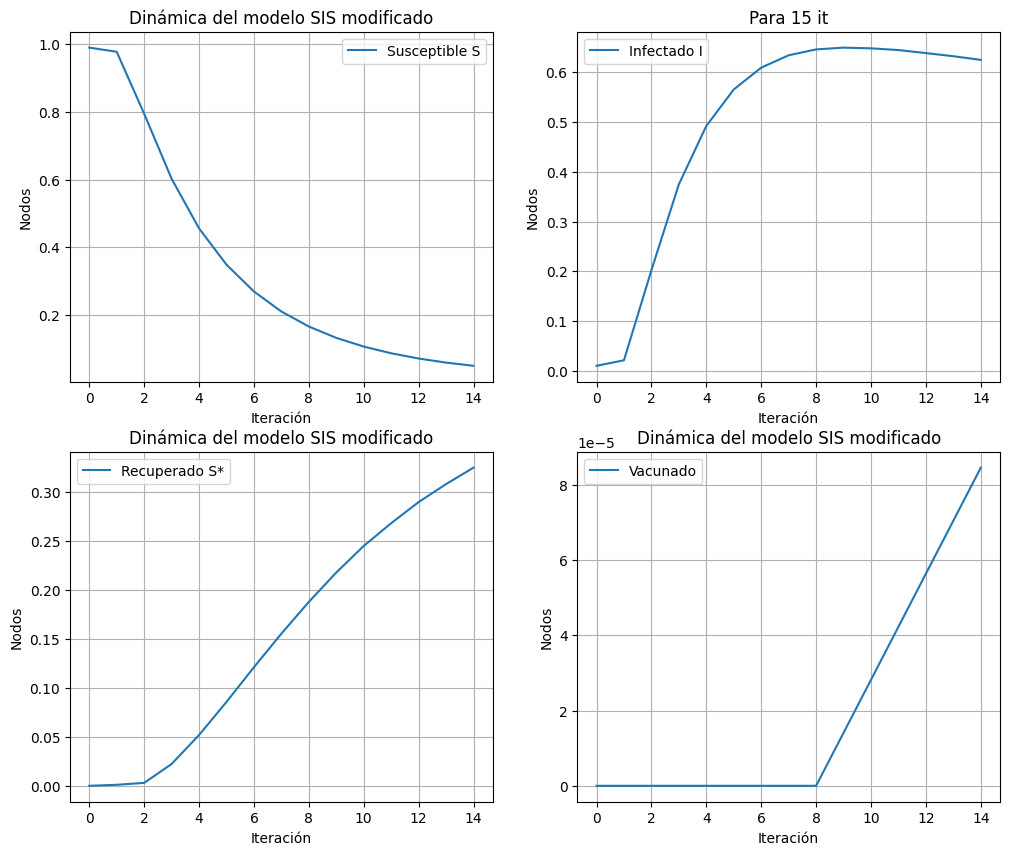

In [ ]:
# -- Red
p_inf = 0.01 # Porcentaje de infectados
iter = 150 # Iteracion

# -- Enfermedad
a1 = 0.3 # Prob de S a I
b = 0.1 # Prob de I a S*
a2 = a1/3 # Prob de S* a I
dv = 8
mv = 15

# --------------------------------------
# Inicializamos los estados
for nodo in net.nodes():
  net.nodes[nodo]['Estado'] = 'I' if random.random() < p_inf else 'S'

# ------------------------------------
_states = [ net.nodes[nodo]['Estado'] for nodo in net.nodes() ]
_S = Counter(_states)['S']
_I = Counter(_states)['I']

# ---------------------------------
def contador(red):
    counts = {'S': 0, 'I': 0, 'S*': 0, 'V':0}
    for nodo in red.nodes:
        counts[ red.nodes[nodo]['Estado'] ] += 1
    return counts

# -------------------------------------
contador_estados = []
images = []
for it in tqdm(range(iter), desc = 'Propagación de la enfermedad'): # Consideramos 1k dias
  nuevos_estados = {} # Almacenamos el estado de la red

  max_v = 0

  for nodo in net.nodes: # Para cada nodo de los posibles nodos
    if net.nodes[nodo]['Estado'] == 'S': # Si el estado es susceptible
      # Obtiene a los vecinos
      cluster_infectados = sum(
          [1 for vecino in net.neighbors(nodo) if net.nodes[vecino]['Estado'] == 'I']
       )

      # Definimos el nuevo estado

      if (nodo in hubs and it >= dv and max_v <= mv ):
        nuevos_estados[nodo] = 'V'
        max_v +=1


      elif random.random() < 1 - (1 - a1)**cluster_infectados: # Elif to if
        nuevos_estados[nodo] = 'I'

      else:
        nuevos_estados[nodo] = 'S'


    elif net.nodes[nodo]['Estado'] == 'I': # Si tenemos un infectado

      if random.random() < b:
        nuevos_estados[nodo] = 'S*'

      else:
        nuevos_estados[nodo] = 'I'

    elif net.nodes[nodo]['Estado'] == 'S*': # Estado Susceptible

      cluster_infectados = sum(
          [1 for vecino in net.neighbors(nodo) if net.nodes[vecino]['Estado'] == 'I']
       )

      # Definimos el nuevo estado

      if (nodo in hubs and it >= dv and max_v <= mv):
        nuevos_estados[nodo] = 'V'
        max_v +=1


      elif random.random() < 1 - (1 - a2)**cluster_infectados: # elif to if
        nuevos_estados[nodo] = 'I'

      else:
        nuevos_estados[nodo] = 'S*'

    elif net.nodes[nodo]['Estado']== 'V':
      nuevos_estados[nodo] = 'V' # Consideramos que los vacunados ya no pueden volver a infectar

    else:
      print('Esto no deberia pasar')


    # Actualizamos
  for nodo, ns in nuevos_estados.items():
    net.nodes[nodo]['Estado'] = ns

    # Almacenamos el historial

  contador_estados.append(contador(net))
  images.append(state_to_matrix(net))

# ----------------------------------------------
dias = range(iter+1)

Sv = np.array( [_S] + [estado['S'] for estado in contador_estados])/nodos
Iv = np.array([_I] + [estado['I'] for estado in contador_estados])/nodos
S_v = np.array([0] + [estado['S*'] for estado in contador_estados])/nodos
Vv = np.array([0] + [estado['V'] for estado in contador_estados])/nodos

# -------------------------------------------------
# Grafica
n = 15
r = 10
plt.figure(figsize=(r+2, r ))
plt.subplot(2, 2, 1)
plt.plot(dias[:n], Sv[:n], label ='Susceptible S')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 2)
plt.plot(dias[:n], Iv[:n], label ='Infectado I')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Para {} it'.format(n))

plt.subplot(2, 2, 3)
plt.plot(dias[:n], S_v[:n], label ='Recuperado S*')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 4)
plt.plot(dias[:n], Vv[:n], label ='Vacunado')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.show()

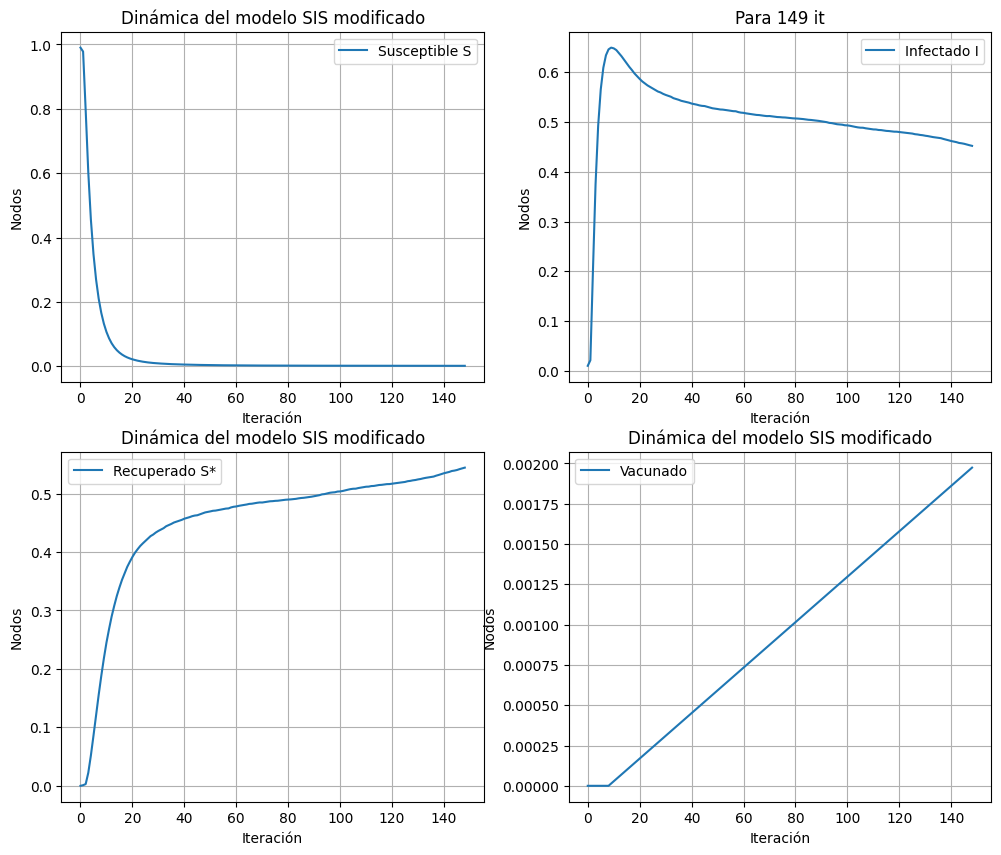

In [ ]:
# Grafica
n = iter - 1
r = 10
plt.figure(figsize=(r+2, r ))
plt.subplot(2, 2, 1)
plt.plot(dias[:n], Sv[:n], label ='Susceptible S')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 2)
plt.plot(dias[:n], Iv[:n], label ='Infectado I')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Para {} it'.format(n))

plt.subplot(2, 2, 3)
plt.plot(dias[:n], S_v[:n], label ='Recuperado S*')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.subplot(2, 2, 4)
plt.plot(dias[:n], Vv[:n], label ='Vacunado')
plt.xlabel('Iteración')
plt.ylabel('Nodos')
plt.legend()
plt.grid()
plt.title('Dinámica del modelo SIS modificado')

plt.show()

Guardamos los resultados de la difusión:

In [ ]:
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/SvHUB.npy', Sv)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/IvHUB.npy', Iv)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/S_vHUB.npy', S_v)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/VvHUB.npy', Vv)
np.save('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulationHUB.npy', np.array(images) )

In [ ]:
#await send_sms_to_me('HUBS Diffusion Completed!')

In [ ]:
def matrix_to_video(matrix, output_path):
  data = matrix.astype(np.uint8)
  fps = 1
  height, width, _ = data.shape[1:]

  # Inicializamos el escritor de video
  fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec para MP4
  out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

  # Iteramos sobre cada frame y lo escribimos en el video
  for frame in data:
    out.write(frame)

  # Liberamos el objeto del video
  out.release()

  print(f"Video guardado en {output_path}")

In [ ]:
output_path = ('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulationHUB.mp4')
matrix = np.load('/content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulationHUB.npy')

matrix_to_video(matrix, output_path)

Video guardado en /content/drive/MyDrive/Coding/Python_Notebooks/Network_Science/COVID19_simulationHUB.mp4


In [ ]:
#await send_sms_to_me('All saved!')

El vídeo obtendio puede consultarse en [Propagación de Enfermedad con Vacunación sobre los Hubs](https://youtube.com/shorts/XVsRyK4-xVo?feature=share)

## Conclusión

* La red de YT posee cerca de 1 millón de nodos con cerca de 3 millones de enlaces. Estos se interpretan como relaciones entre los usuarios de la red.

* El grado promedio de la red es de 5.27, con un valor esperado de clustering de 8e-2.

* El diámetro de la red para los primeros 5k nodos es de 5. Mientras que el valor reportado es de 20.

* La métrica de cercanía sugiere que los usuarios forman comunidades de manera escasa y constante, con un comportamiento ligeramente oscilante entre los usuarios. La métrica de intermediación sugiere la presencia de Hubs dentro de la red, dado que encontramos usuarios que poseen un valor alto de intermediación, siendo el promedio casi nulo.

* La distribución de grado en escala logarítmica sugiere una independencia de escala presente en la misma.

* La red no satisface la propiedad de mundo pequeño, mientras que cumple poseer un diámetro pequeño en relación a la cantidad de nodos, no posee un valor de clustering alto.

* La red no es modelable a partir de ER, el valor de clustering y la probabilidad asociada difieren en 4 órdenes de magnitud, y la distribución de probabilidad de grado no se ajusta a la curva esperado de Poisson.

* La red presenta independencia de escala, la distribución de probabilidad de grado se ajusta a una ley de potencia con $\alpha = 2.48$ y $k_{min} = 206$.

* El proceso de difusión de modelación de epidemias sugiere la ineficacia en la vacunación aleatoria, dado que se requiere de la vacunación del 90% de la población. En cambio la vacunación a los Hubs que representan el 0.2% de la población alcanza el mismo resultado.

